# Import libraries

In [1]:
import obspy
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import tukey
from mtspec import mtspec
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 16})


# Read data and remove instrument response

/Users/antonio/opt/anaconda3/envs/mtspec/lib/python3.6/site-packages/obspy/io/xseed/parser.py:1382: UserWarning: Epoch IG.PNIG..HHE [1994-03-28T00:00:00.000000Z - None]: Stage 2 has 3 blockettes 58. Only the last one will be used.
  warnings.warn(_epoch_warn_msg(msg))
/Users/antonio/opt/anaconda3/envs/mtspec/lib/python3.6/site-packages/obspy/io/xseed/parser.py:1382: UserWarning: Epoch IG.PNIG..HHE [1994-03-28T00:00:00.000000Z - None]: Stage 4 has 2 blockettes 58. Only the last one will be used.
  warnings.warn(_epoch_warn_msg(msg))
/Users/antonio/opt/anaconda3/envs/mtspec/lib/python3.6/site-packages/obspy/io/xseed/parser.py:1382: UserWarning: Epoch IG.PNIG..HHN [1994-03-28T00:00:00.000000Z - None]: Stage 2 has 3 blockettes 58. Only the last one will be used.
  warnings.warn(_epoch_warn_msg(msg))
/Users/antonio/opt/anaconda3/envs/mtspec/lib/python3.6/site-packages/obspy/io/xseed/parser.py:1382: UserWarning: Epoch IG.PNIG..HHN [1994-03-28T00:00:00.000000Z - None]: Stage 4 has 2 blockette

max:  1.40197740007e-06


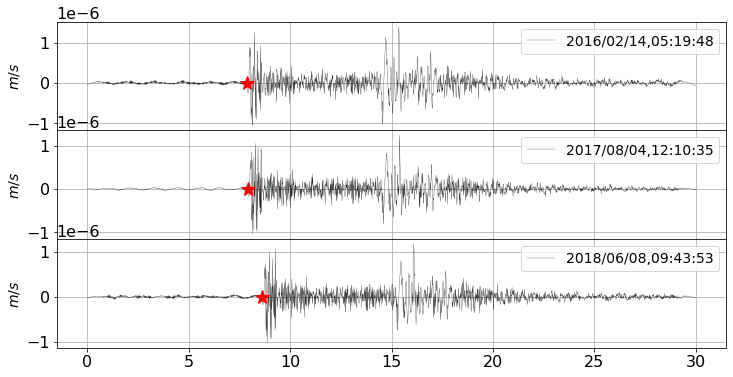

In [2]:
sac = obspy.read('./sac/PNIG.IG.HHZ.*.sac')
res = sac.copy()

RESP_FILE = './sac/PNIG.RESP';
inv       = obspy.read_inventory(RESP_FILE)
pre_filt  = [0.5, 1, 30, 40]

resp_type   = "VEL"
dict_ylabel = {"DISP" : f"$m$", "VEL" : f"$m/s$", "ACC" : f"$m/s^2$"}
dict_title  = {"DISP" : "Displacement", "VEL" : "Velocity", "ACC" : "Acceleration"}

res.detrend()
res.taper(max_percentage=0.05)
res.remove_response(inventory=inv, output=resp_type,zero_mean=True, pre_filt=pre_filt, taper=True)
Nsac    = len(res)
fig, ax = plt.subplots(Nsac,1, figsize = (12,6), sharex=True)

k    = 0
date = {}
Rij  = {}
dt   = {}
mag  = {}


for tr in res:
    date[k] = tr.stats.starttime.strftime("%Y/%m/%d,%H:%M:%S")
    Rij[k]  = np.sqrt(tr.stats.sac.dist**2+tr.stats.sac.evdp**2)*1e3
    dt[k]   = tr.stats.delta
    mag[k]  = tr.stats.sac.mag
    ax[k].plot(tr.times(),tr.data,'k',linewidth=0.25, label=date[k])
    ax[k].plot(tr.stats.sac.t5,0,'r*',markersize=15)
    ax[k].grid()
    ax[k].legend(fontsize=14)
    ax[k].set_ylabel(dict_ylabel[resp_type],fontsize=14)
    k+=1

plt.subplots_adjust(hspace=0, wspace=0)


print('max: ', np.max(res[0].data))

# Trim to P- wave

Tp:  7.89  tpn:  789  tnbef:  50  npts:  256
Tp:  7.91  tpn:  791  tnbef:  50  npts:  256
Tp:  8.63  tpn:  864  tnbef:  50  npts:  256


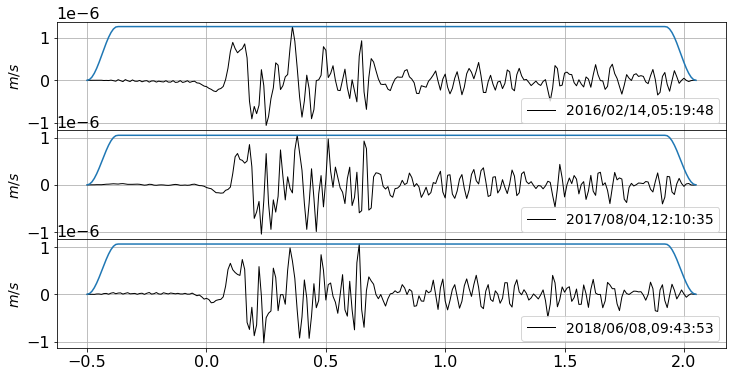

In [4]:
tbef  = 0.5
Nfft  = 256

k       = 0 
d       = {}
fig, ax = plt.subplots(Nsac,1, figsize = (12,6), sharex=True)

for tr in res:
    t     = tr.times()
    dt[k] = tr.stats.delta
    tpn   = np.argmax(t >= tr.stats.sac.t5)
    tnbef = int(np.floor(tbef/dt[k]))
    d[k]  = tr.data[tpn - tnbef:tpn - tnbef + Nfft] - np.mean(tr.data[tpn - tnbef:tpn - tnbef + Nfft])
    taper = tukey(Nfft, alpha=0.1)
    d[k]  = np.multiply(d[k],taper)
    ax[k].plot(np.linspace(-0.5,(Nfft-1)*dt[k]-0.5,Nfft),d[k],'k',linewidth=1, label=date[k])
    ax[k].legend(fontsize=14)
    ax[k].set_ylabel(dict_ylabel[resp_type],fontsize=14)
    ax[k].plot(np.linspace(-0.5,(Nfft-1)*dt[k]-0.5,Nfft),taper*np.max(d[k]))
    ax[k].grid()
    print('Tp: ', tr.stats.sac.t5, ' tpn: ', tpn, ' tnbef: ', tnbef, ' npts: ', len(d[k]))
    k     = k + 1
    
plt.subplots_adjust(hspace=0, wspace=0)

# Estimate the sprectrum

<class 'dict'>


Text(0.5, 1.0, 'Spectrum Velocity')

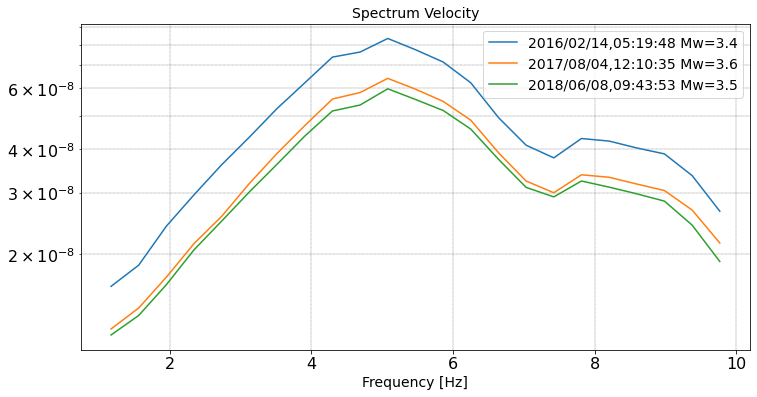

In [5]:
k = 0
fmin = 1
fmax = 10
print(type(d))

Aspec   = {}
fspec   = {}

fig, ax = plt.subplots(1,1, figsize = (12,6))
for key, tr in d.items():
    
    spec, freq = mtspec(data=tr, delta=dt[key], time_bandwidth=3, nfft=len(tr))
    spec       = np.sqrt(spec/2)
    index      = np.where(np.logical_and(freq>=fmin, freq<=fmax))
    
    Aspec[key] = spec[index]
    fspec[key] = freq[index]
    
    ax.semilogy(fspec[key],Aspec[key],label=date[key] + ' Mw=' + str(mag[key]))
    k = k + 1

ax.legend(fontsize=14)
ax.grid(b=True, which='major', color='k', linestyle='--',linewidth=0.25)
ax.grid(b=True, which='minor', color='k', linestyle='--',linewidth=0.25)
plt.xlabel('Frequency [Hz]',fontsize=14)
plt.title('Spectrum ' + dict_title[resp_type], fontsize=14)

# Geometrical spreading
**See:**
*García, D., Singh, S.K., Herraiz, M., Ordaz, M., Pacheco, J.F. and Cruz-Jiménez, H., 2009. Influence of subduction zone structure on coastal and inland attenuation in Mexico. Geophysical Journal International, 179(1), pp.215-230.*

C:  2.55316239354e-13
Rij:  48644.1860008  G(Rij):  2.0557441335e-05 log10(G):  -4.68703094042
Rij:  46558.3177743  G(Rij):  2.14784392522e-05 log10(G):  -4.66799728018
Rij:  48731.4096307  G(Rij):  2.05206458745e-05 log10(G):  -4.6878089742


Text(0.5, 1.0, 'Spectrum Velocity')

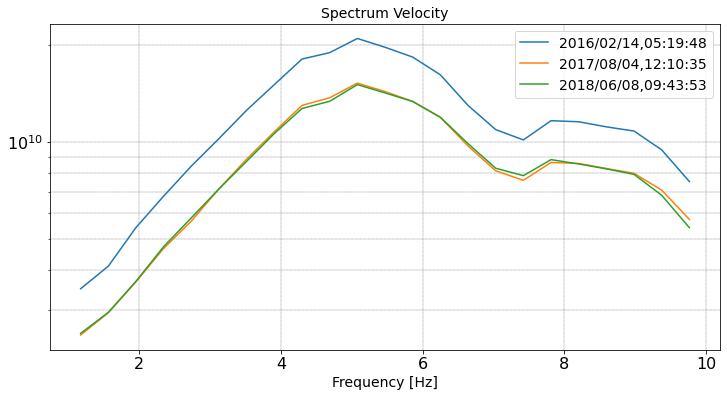

In [8]:
def G(r):
    R0 = 100e3
    if r <= R0:
        return 1/r
    else:
        
        return 1/np.sqrt(R0*r)
def Q(f):
    return 211*np.power(f,0.46)

Slog = {}
vel  = 3600*np.sqrt(3)

Rad = 0.55             # Radiation pattern Boore and Boatwright
F   = 2.0              # Free surface
P   = 1/np.sqrt(2)     # Energy partioning
rho = 2700           
C   = Rad*F*P/(4*np.pi*(vel**3))
print('C: ', C)

fig, ax = plt.subplots(1,1, figsize = (12,6))
S       = {}
for key, An in Aspec.items():
    Slog[key] = np.log10(An) - np.log10(G(Rij[key])) + 1.36*fspec[key]*Rij[key]/(vel*Q(fspec[key])) - np.log10(C)
    S[key]    = 10**(Slog[key]) 
    ax.semilogy(fspec[key],S[key], label=date[key] )
    print("Rij: ", Rij[key], " G(Rij): ", G(Rij[key]), "log10(G): ", np.log10(G(Rij[key])))
    
ax.legend(fontsize=14)
ax.grid(b=True, which='major', color='k', linestyle='--',linewidth=0.25)
ax.grid(b=True, which='minor', color='k', linestyle='--',linewidth=0.25)   
plt.xlabel('Frequency [Hz]',fontsize=14)
plt.title('Spectrum ' + dict_title[resp_type], fontsize=14)

# Brune spectrum

M0:  1.58489371451e+14
M0:  3.16227661855e+14
M0:  2.23872113857e+14


Text(0.5, 1.0, 'Brune Spectrum Velocity')

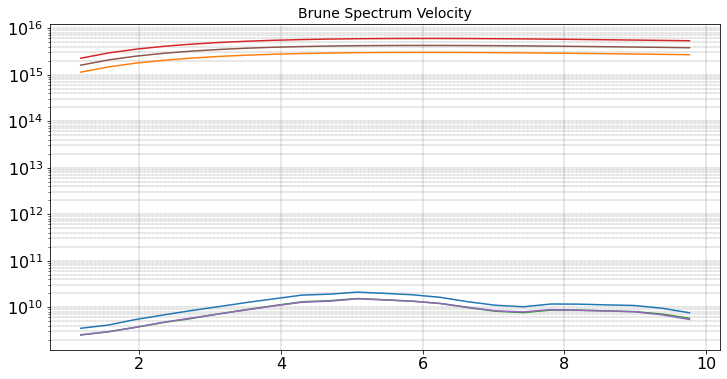

In [9]:


def M0_func(Mw):
    return np.power(10,Mw*1.5+9.1)
def brune_spectrum(f,fc):
    print('M0: ', M0)
    if resp_type == "DISP":
        Sb = M0/(1+(f/fc)**2)
    elif resp_type == "VEL":
        Sb = M0*(2*np.pi*f)/(1+(f/fc)**2)
    elif resp_type == "ACC":
        Sb = M0*(2*np.pi*f)**2/(1+(f/fc)**2)
    else:
        None
    return Sb

fig, ax = plt.subplots(1,1, figsize = (12,6))
for key, fb in fspec.items():
    M0 = M0_func(mag[key])
    ax.semilogy(fspec[key],S[key], label=date[key] )
    ax.semilogy(fb, brune_spectrum(fb, 6.0))
    
ax.grid(b=True, which='major', color='k', linestyle='--',linewidth=0.25)
ax.grid(b=True, which='minor', color='k', linestyle='--',linewidth=0.25)   
plt.title('Brune Spectrum ' + dict_title[resp_type], fontsize=14)